# DTSA 5509 Final Project
## Cervical Cancer Risk Classification

### Overview of Dataset

I chose to use a dataset called **Cervical Cancer (Risk Factors)** publicly available on the UC Irvine Machine Learning Repository.

Link to dataset on UCI website: https://archive.ics.uci.edu/dataset/383/cervical+cancer+risk+factors

Here is the **citation** for this data:

Fernandes, K., Cardoso, J., & Fernandes, J. (2017). Cervical Cancer (Risk Factors) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5Z310.

This dataset was published in 2017 and was collected by the Hospital Universitario de Caracas in Venezuela. From a survey of 858 total patients, results were collected on different risk factors for cervical cancer, including demographic information, medical history, and individual habits. Missing values are present for some patients who chose not to answer certain survey questions.

Cervical cancer is the third most common type of cancer found in women, and early detection and understanding of risk factors are critical steps in prevention and treatment.
The goal of this analysis is to predict whether a patient has cervical cancer or not based on their combination of risk factors. To accomplish this, I will be using **logistic regression** and an **XGBoost gradient boosting** method to perform a classification task and compare results across each method, predicting whether the target "Biopsy" will be 1 (indicating presence of cervical cancer) or 0.


## Data Cleaning & Pre-processing

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb

pd.set_option('display.max_columns', None)

# Importing data from a CSV on my local machine
raw_data = pd.read_csv('kag_risk_factors_cervical_cancer.csv')

# Drop question marks from cells and replace with NaN values
cleaned_data = raw_data.replace('?', None)

# Drop fields with data that is too sparse to be usable
cleaned_data = cleaned_data.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)

print(cleaned_data.info())
print(cleaned_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           832 non-null    object
 2   First sexual intercourse            851 non-null    object
 3   Num of pregnancies                  802 non-null    object
 4   Smokes                              845 non-null    object
 5   Smokes (years)                      845 non-null    object
 6   Smokes (packs/year)                 845 non-null    object
 7   Hormonal Contraceptives             750 non-null    object
 8   Hormonal Contraceptives (years)     750 non-null    object
 9   IUD                                 741 non-null    object
 10  IUD (years)                         741 non-null    object
 11  STDs                                753 non-null    object

This dataset contains 858 total observations. There are 33 total features, 10 numerical and 23 categorical.

Even though the data summary shows 858 non-null observations in all fields, the actual dataset contains question marks ("?") in many cells with missing values.
Once the null values are removed, we are left with 33 feature columns and 1 target ("Biopsy"). Of the 33 total features, 24 have some missing values.

Using the table produced by df.describe(), there are no values that appear to be outliers that need to be dealt with before model training/analysis.

Importantly, this dataset is highly imbalanced, with far more negative Biopsy samples than positive ones. I take this into account with how I build and evaluate models in future steps.

### Description of features

The features in this dataset represent different pieces of medical information collected for 858 distinct patient profiles. Some are self explanatory such as:
* Age: Age of patient in years
* Number of sexual partners: Self-reported by patient

Others are binary classes, where 1 indicates a positive result and 0 a negative:
* Smokes: Patient's smoking status (binary 1 or 0)
* Hormonal Contraceptives: Patient's use of hormonal contraceptives (binary 1 or 0)
* STDs:Hepatitis B: Patient has been diagnosed with Hepatitis B

The target column is called "Biopsy" and is a binary class where 1 indicates a patient has been diagnosed with cervical cancer and 0 indicates they have not.

Before further modeling and analysis, it seems likely to me that there would be a relationship between the presence of STDs and higher rates of cancer. Because the features named Hinselmann, Schiller, and Citology refer to different chemical lab tests that detect abnormal cells in cervical tissue, it also seems reasonable to assume that positive results in these features would also be associated with a higher positive Biopsy rate.
I don't have specific domain knowledge that leads me to exclude any columns as part of data cleaning before proceeding.

### Exploring feature distributions

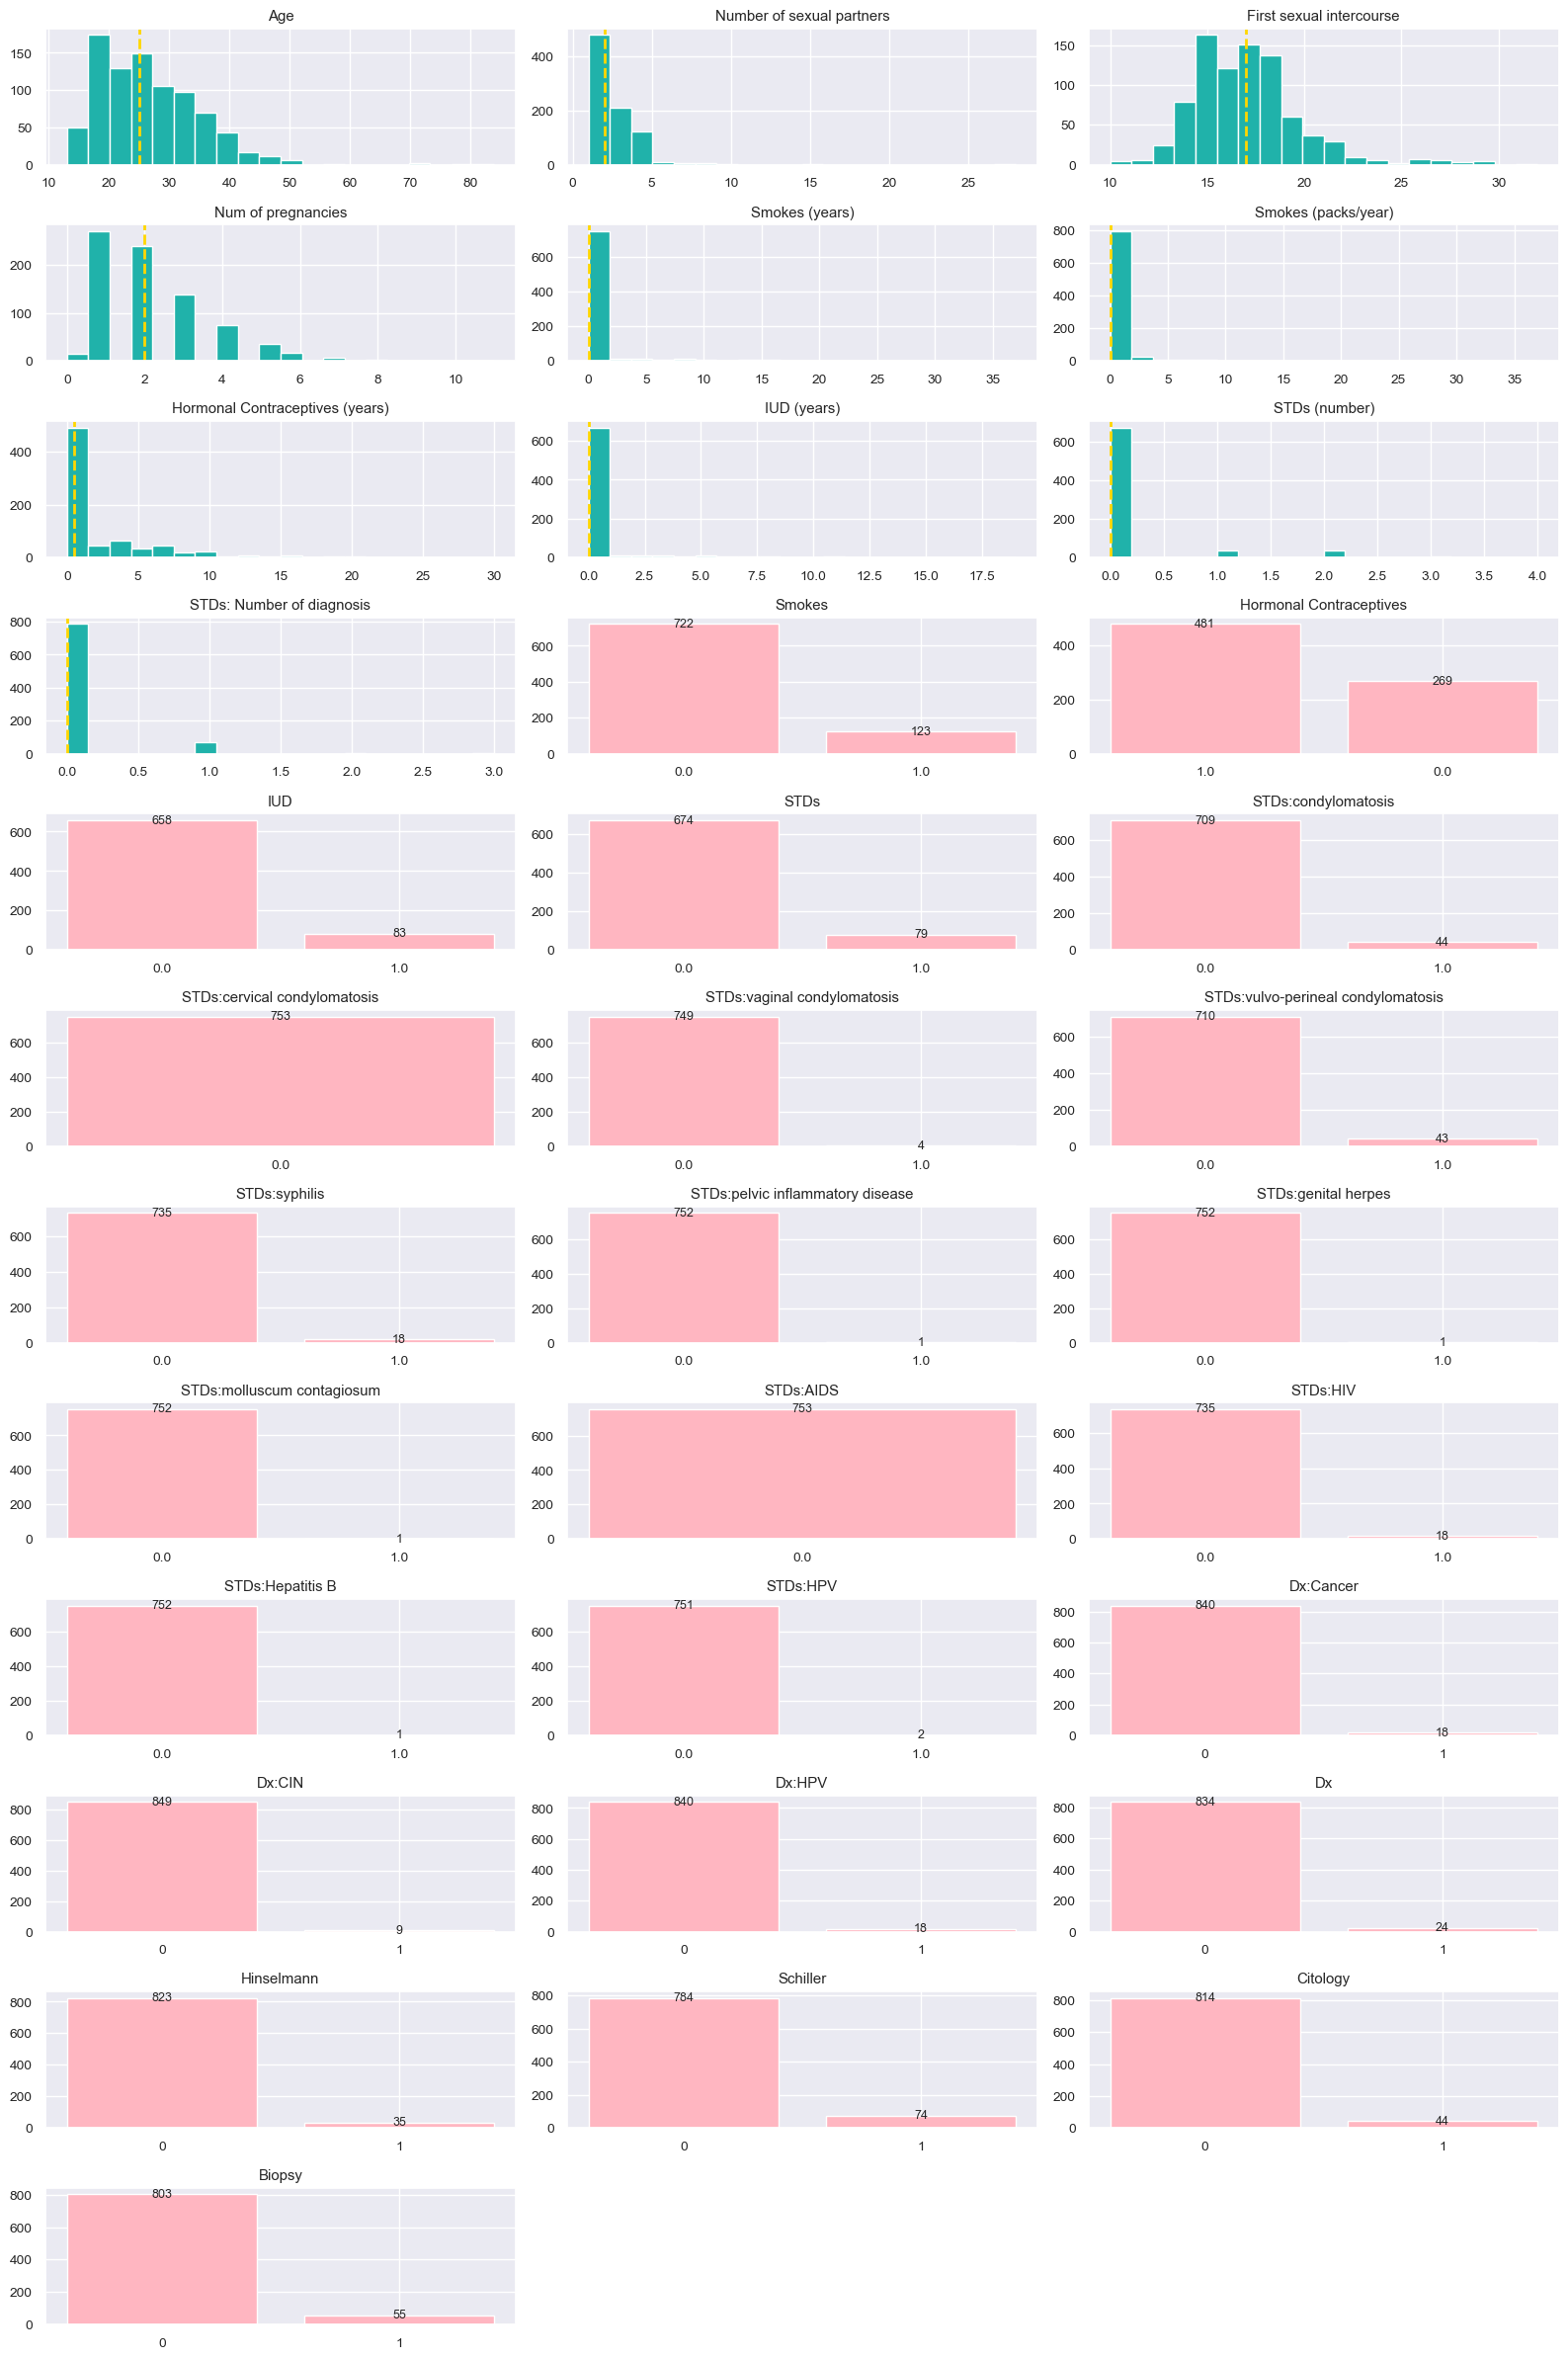

In [101]:
dtype_dict_primary = {'Age': 'int64',
              'Number of sexual partners': 'float',
              'First sexual intercourse': 'float',
              'Num of pregnancies': 'float',
              'Smokes': 'category',
              'Smokes (years)': 'float',
              'Smokes (packs/year)': 'float',
              'Hormonal Contraceptives': 'category',
              'Hormonal Contraceptives (years)': 'float',
              'IUD': 'category',
              'IUD (years)': 'float',
              'STDs': 'category',
              'STDs (number)': 'float',
              'STDs:condylomatosis': 'category',
              'STDs:cervical condylomatosis': 'category',
              'STDs:vaginal condylomatosis': 'category',
              'STDs:vulvo-perineal condylomatosis': 'category',
              'STDs:syphilis': 'category',
              'STDs:pelvic inflammatory disease': 'category',
              'STDs:genital herpes': 'category',
              'STDs:molluscum contagiosum': 'category',
              'STDs:AIDS': 'category',
              'STDs:HIV': 'category',
              'STDs:Hepatitis B': 'category',
              'STDs:HPV': 'category',
              'STDs: Number of diagnosis': 'float',
              'Dx:Cancer': 'category',
              'Dx:CIN': 'category',
              'Dx:HPV': 'category',
              'Dx': 'category',
              'Hinselmann': 'category',
              'Schiller': 'category',
              'Citology': 'category',
              'Biopsy': 'category'
             }

cleaned_data = cleaned_data.astype(dtype_dict_primary)

# Identify target and features in dataset
target_col = 'Biopsy'
features = [f for f in cleaned_data.columns] # if f != target_col]

# Create an array of the features
features_arr = [cleaned_data[feat] for feat in features]

# Sort features so that numerical and categorical variables appear together
numerical_features = []
categorical_features = []
for feature in features_arr:
    f = pd.Series(feature)
    if f.dtype.name == "category":
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)
# Recombine num and cat features
sorted_features = numerical_features + categorical_features

# Identify boundaries of grid where plots will be displayed
n = len(features_arr)
cols = 3
rows = (np.ceil(n / cols)).astype('int64')

# Set up subplots in grid
fig, axes = plt.subplots(rows, cols, figsize=(16, 24))
axes = axes.ravel()

# For each feature, create histogram (for numerical) or bar chart (for categorical)
for i, data in enumerate(sorted_features):
    # For numerical dtypes, create histogram
    if data.dtype == 'float' or data.dtype == 'int64':
        vals = data.astype(float)
        axes[i].hist(vals, bins=20, color='lightseagreen')
        
        # Add vertical line to indicate median of dsitribution
        feature_median = vals.median()
        axes[i].axvline(x=feature_median, linestyle='--', linewidth=2, color='gold')
    # For binary categorical vars, a bar chart acts like a histogram for showing the distribution
    elif data.dtype == 'category':
        valcounts = data.value_counts()
        axes[i].bar(valcounts.index.astype(str), valcounts.values, color='lightpink')
        for x, val in enumerate(valcounts.values):
            axes[i].text(x, val, f"{val:0.0f}", ha="center", va="center", fontsize=9)
    axes[i].set_title(f"{data.name}")
        
# Finally hide empty subplots
for j in range(i+1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Imputing missing data

I decided to impute missing values. The features that are missing values are missing 10-14% and we can make reasonable assumptions about their values. I already dropped two features that were extremely sparsely populated.

In [7]:
# Separating numerical and categorical dtypes
num_cols = cleaned_data.select_dtypes(include=['int64','float']).columns
cat_cols = cleaned_data.select_dtypes(include=['category']).columns

# Create encoder for categorical values
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cleaned_data[cat_cols] = encoder.fit_transform(cleaned_data[cat_cols])

# Create imputer using sklearn library
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)

# Correcting dtypes
dtype_dict_secondary = {'Age': 'int64',
              'Number of sexual partners': 'int64',
              'First sexual intercourse': 'int64',
              'Num of pregnancies': 'int64',
              'Smokes': 'float',
              'Smokes (years)': 'float',
              'Smokes (packs/year)': 'float',
              'Hormonal Contraceptives': 'category',
              'Hormonal Contraceptives (years)': 'float',
              'IUD': 'category',
              'IUD (years)': 'float',
              'STDs': 'category',
              'STDs (number)': 'float',
              'STDs:condylomatosis': 'category',
              'STDs:cervical condylomatosis': 'category',
              'STDs:vaginal condylomatosis': 'category',
              'STDs:vulvo-perineal condylomatosis': 'category',
              'STDs:syphilis': 'category',
              'STDs:pelvic inflammatory disease': 'category',
              'STDs:genital herpes': 'category',
              'STDs:molluscum contagiosum': 'category',
              'STDs:AIDS': 'category',
              'STDs:HIV': 'category',
              'STDs:Hepatitis B': 'category',
              'STDs:HPV': 'category',
              'STDs: Number of diagnosis': 'int64',
              'Dx:Cancer': 'category',
              'Dx:CIN': 'category',
              'Dx:HPV': 'category',
              'Dx': 'category',
              'Hinselmann': 'category',
              'Schiller': 'category',
              'Citology': 'category',
              'Biopsy': 'category'
             }
df_imputed = df_imputed.astype(dtype_dict_secondary)

print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Age                                 858 non-null    int64   
 1   Number of sexual partners           858 non-null    int64   
 2   First sexual intercourse            858 non-null    int64   
 3   Num of pregnancies                  858 non-null    int64   
 4   Smokes                              858 non-null    float64 
 5   Smokes (years)                      858 non-null    float64 
 6   Smokes (packs/year)                 858 non-null    float64 
 7   Hormonal Contraceptives             858 non-null    category
 8   Hormonal Contraceptives (years)     858 non-null    float64 
 9   IUD                                 858 non-null    category
 10  IUD (years)                         858 non-null    float64 
 11  STDs                            

## Looking for Correlations

To identify likely correlations between different features, I created a correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix of Cervical Cancer Data')

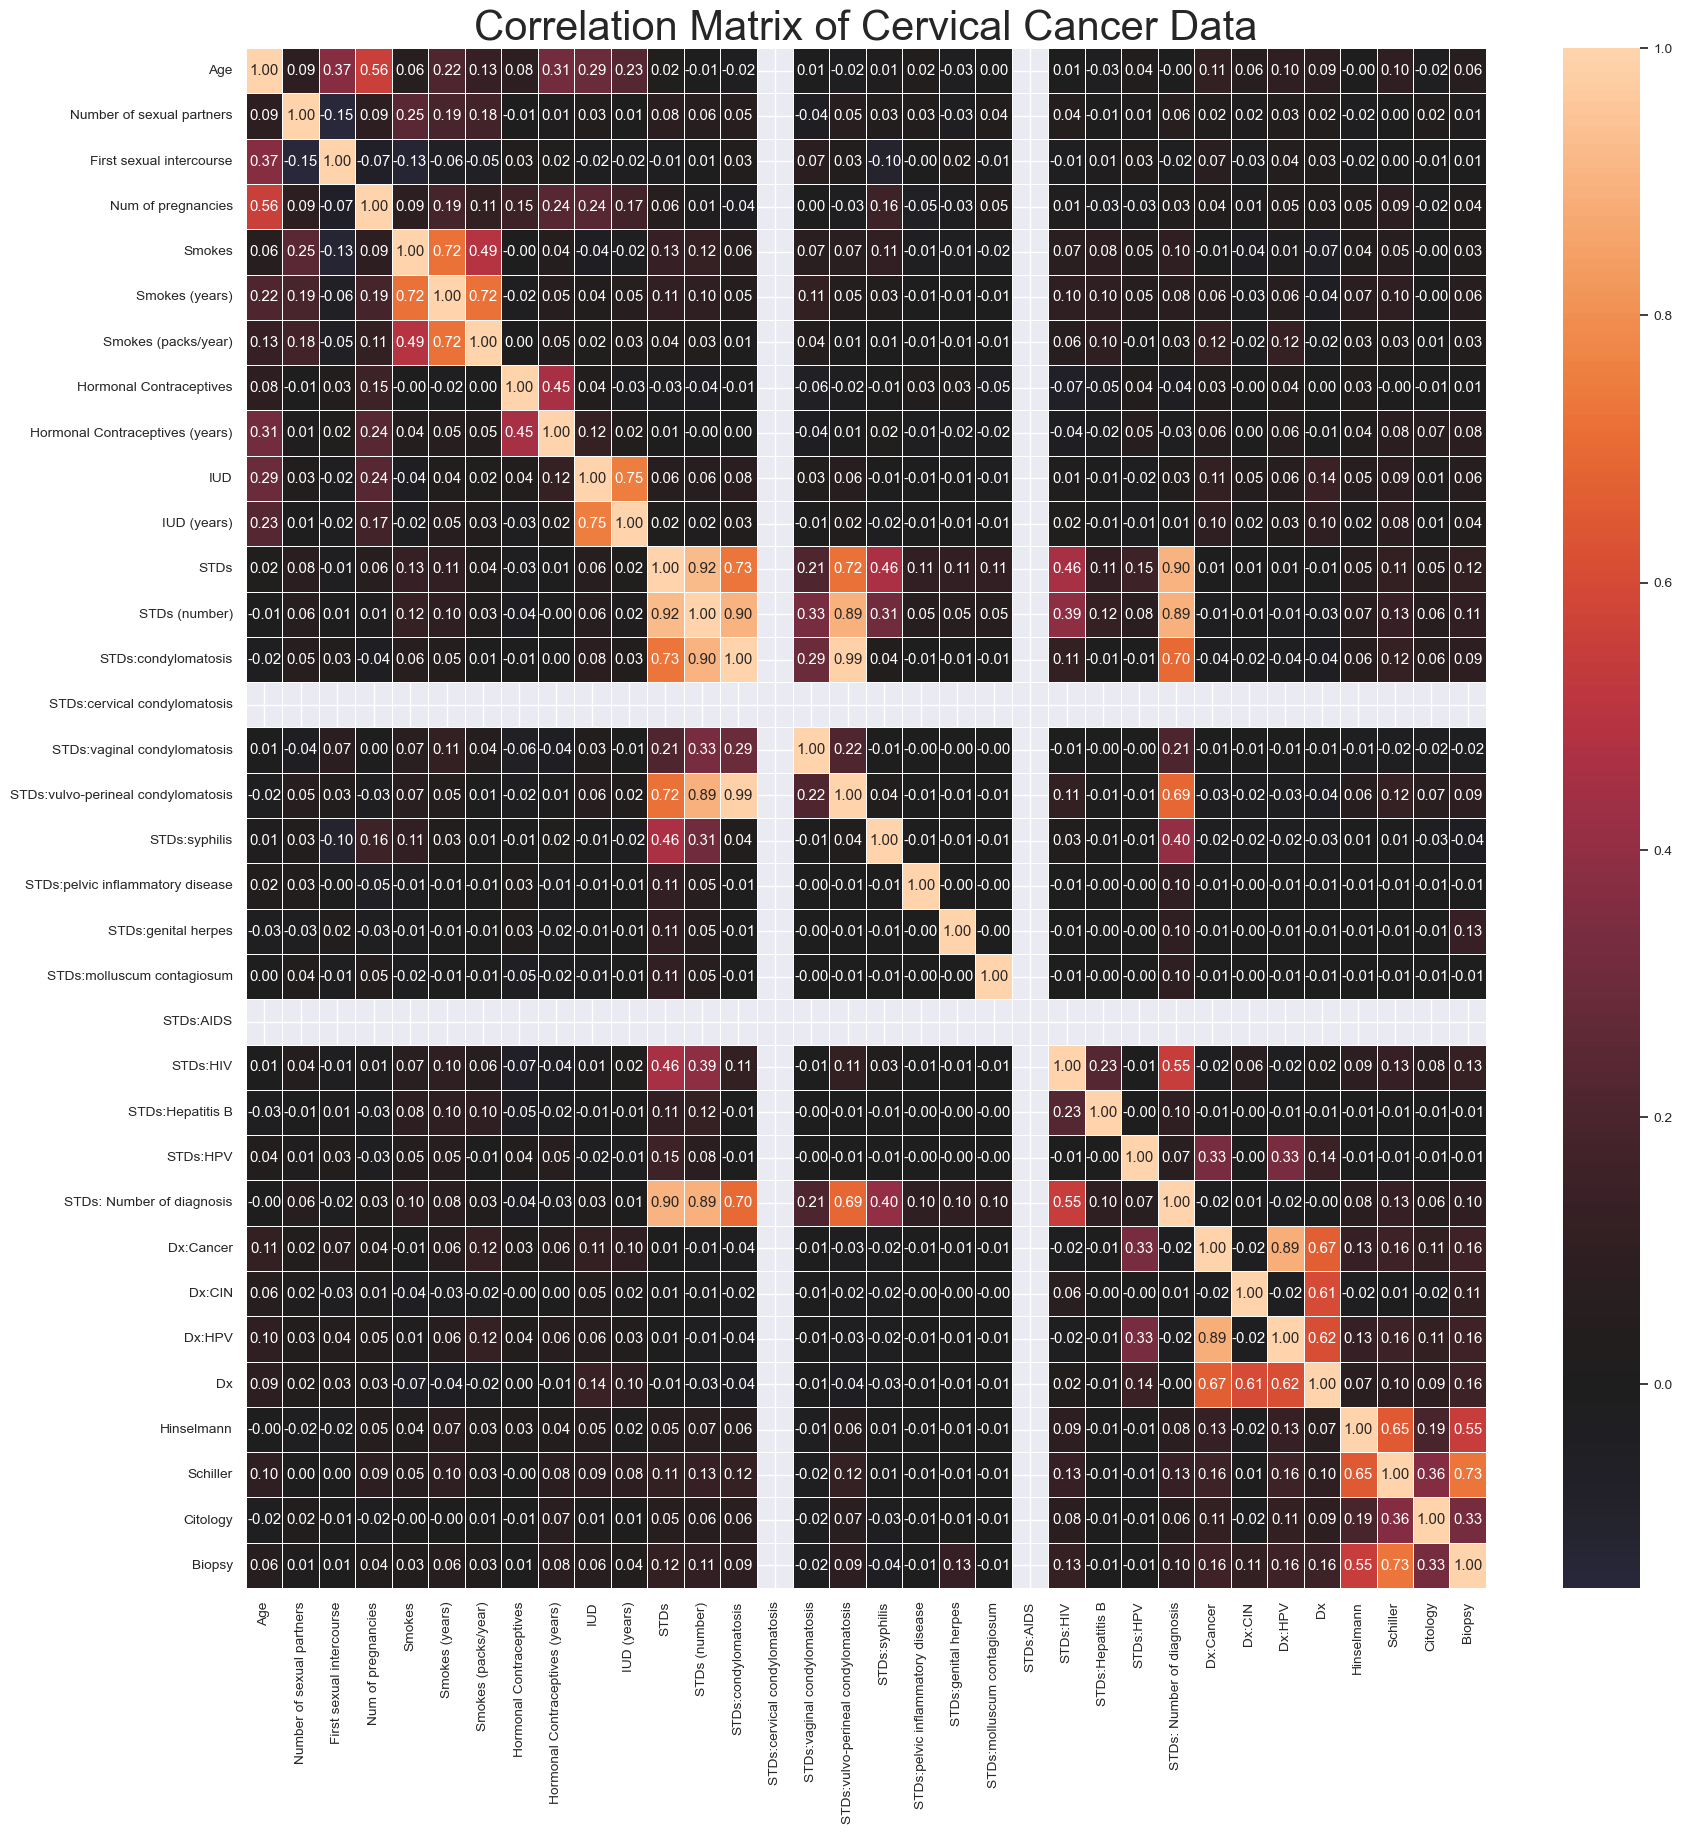

In [103]:
# Create correlation matrix
corr_matrix = df_imputed.corr()

# Get col names for axis labels
cols_list = list(df_imputed.columns)
# Set font size and figure size
sns.set(font_scale=0.90)
plt.figure(figsize=(20,20))

# Create heatmap using seaborn
sns.heatmap(corr_matrix,
            center=0,
            linewidth=0.50,
            xticklabels=cols_list,
            yticklabels=cols_list,
            annot=True,
            fmt="0.2f")
plt.title('Correlation Matrix of Cervical Cancer Data', fontsize=30)

Based on the correlation heatmap above, the strongest predictors of a positive biopsy are the Hinselmann, Schiller, and Citology tests. These features have correlation coefficients with Biopsy that are between 0.33 to 0.73, indicating some level of correlation. This is reasonable, as these features all refer to different methods of screening for different abnormalities in cervical cell samples.

It's also reasonable that the presence of one STD is correlated with the presence of other STDs in the same patient, and that older patients tend to have had a greater number of pregnancies.

## Preparing Data for Training

To prepare for logistic regression, I chose **NOT** to scale the data, since there is not a huge range of data for each feature. After testing out sklearn's StandardScaler, model stability and interpretability were not significantly improved by scaling. Using a log scale is not necessary on a dataset that have ranges of values as closely grouped as this one.

I used sklearn's train_test_split to split the data into test and train sets.

In [105]:
# Separate features from target
feature_df = df_imputed.iloc[:, :-1]
target_df = df_imputed.iloc[:, -1]

# Convert to arrays with numeric values
X = np.array(feature_df).astype('float64')
Y = np.array(target_df).astype('float64')

# Split into test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Logistic Regression Model Training

In [106]:
# Use sklearn's LogisticRegression to train model
logreg = LogisticRegression(solver='liblinear').fit(x_train, y_train)

## Model Evaluation Approah

I used the **liblinear** solver since it is usually efficient for smaller datasets like this one.
Using my trained model, I generated predictions on my x_test data and evaluated the model's predictions with a **confusion matrix**. I will also examine the **accuracy score** (for an easy-to-interpret way of communicating model performance) and the **F1 score** (since this is a relatively unbalanced dataset, with many more negative Biopsy results than positive). I used average **cross-validation accuracy score** to check for consistent scores across different splits.

An **ROC curve** can show the relationship between true positive rate and false positive rate, which is also a helpful way for evaluating the efficacy of this model since false positives can be detrimental to patients. The **false negative rate** is also critical since failing to predict cancer when it is present can cause major damage to patient outcomes.

Below, I wrote an **evaluation_suite** function which can be reused whenever a new model needs to be evaluated and have its performance visualized.

In [107]:
# Evaluation suite
def evaluation_suite(model, model_name, X, Y):
    # Split data and generate predictions
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    y_pred = model.predict(x_test)
    
    # Get cross-validation mean
    cv_mean = np.mean(cross_val_score(model, X, Y, cv=5))
    # Get test accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    # Get F1 score
    f1 = f1_score(y_test, y_pred)
    # Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fn = cm[1,0]
    tp = cm[1,1]
    fnr = fn / (fn + tp)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    # ROC-AUC score and AUC curve
    auc_curve = roc_auc_score(y_test, y_pred)

    # Print metrics
    print(f'{model_name} accuracy score: {accuracy:0.3f}')
    print(f'{model_name} cross-validation mean score: {cv_mean:0.3f}')
    print(f'{model_name} F1 score: {f1:0.3f}')

    # Heatmap viz of confusion matrix
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Greens', fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f'{model_name} false negative rate: {fnr:0.3f}')
    print(f'{model_name} ROC AUC: {auc_curve:0.3f}')

    # AUC curve visualization
    x_ex = np.linspace(0,1,100)
    y_ex = x_ex
    plt.plot(fpr, tpr, color='hotpink')
    plt.plot(x_ex, y_ex, linestyle='dashed', color='lightseagreen')
    plt.fill_between(x=fpr, y1=tpr, color='lightseagreen', alpha=0.1)
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


## Logistic Regression Model Evaluation

LogReg accuracy score: 0.971
LogReg cross-validation mean score: 0.959
LogReg F1 score: 0.762


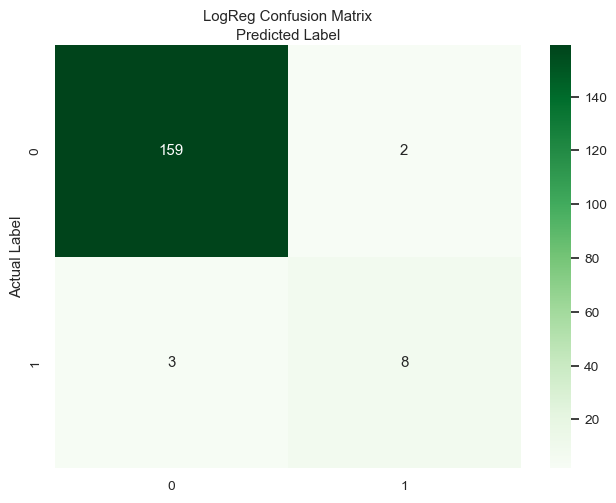

LogReg false negative rate: 0.273
LogReg ROC AUC: 0.857


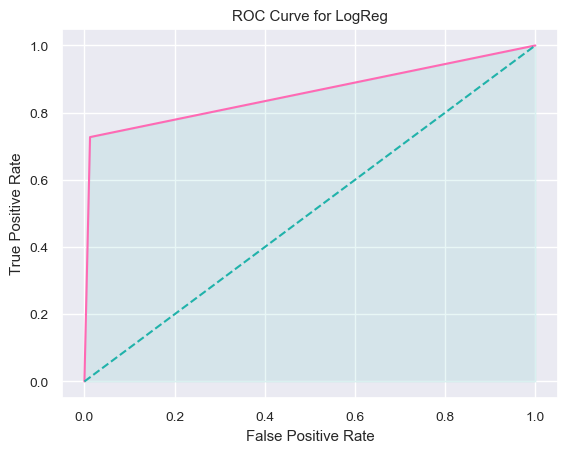

In [108]:
evaluation_suite(model=logreg, model_name='LogReg', X=X, Y=Y)

From these results, we see that we can achieve a **97.1% accuracy** with this logistic regression method, and a mean cross-validation score of 95.9%. This is very good!

However, the F1 score and the ROC curve show that the imbalances in the training data can cause some issues with predictions. In essence, because the large majority of the training data points are negative (0), there is not a lot of positive training examples to train on, so the model has a harder time recognizing positives than it does negatives.

Overall, logistic regression provides a decent method for predicting cancer diagnoses but could be improved with a larger set of positive training examples.

## XGBoost Model Training

I decided to test another method for creating a robust classifier using **XGBoost Gradient Descent**. There are many benefits to this method, but the main one I'm interested in is to evaluate how an ensemble method performs against logistic regression on an imbalanced dataset, and to get more insight into feature importance.

My initial parameters are placeholder "reasonable" values to find a starting place for XGBoost performance. I use scale_pos_weight = (# negative samples)/(# positive samples) to help re-balance the data.

In [109]:
# Train XGBoost model on train set
scale_pos_weight = sum(y_train==0) / sum(y_train==1)
xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100,
                              scale_pos_weight=scale_pos_weight, eval_metric='aucpr'
                             ).fit(x_train, y_train)

## XGBoost Model Evaluation
I then repeated the same evaluation metrics that I used on LogReg to get an apples-to-apples comparison.

XGBoost accuracy score: 0.948
XGBoost cross-validation mean score: 0.953
XGBoost F1 score: 0.690


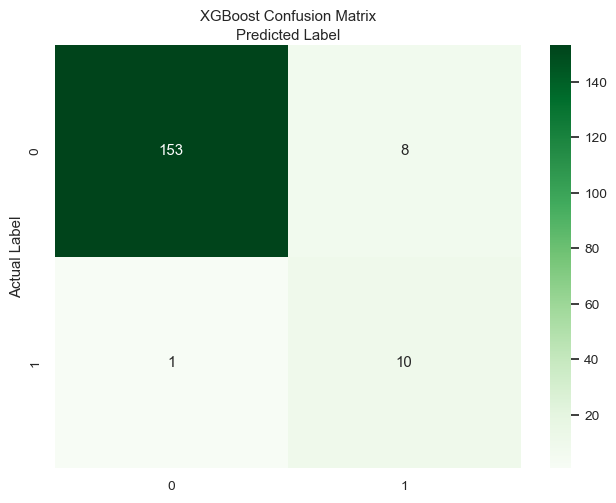

XGBoost false negative rate: 0.091
XGBoost ROC AUC: 0.930


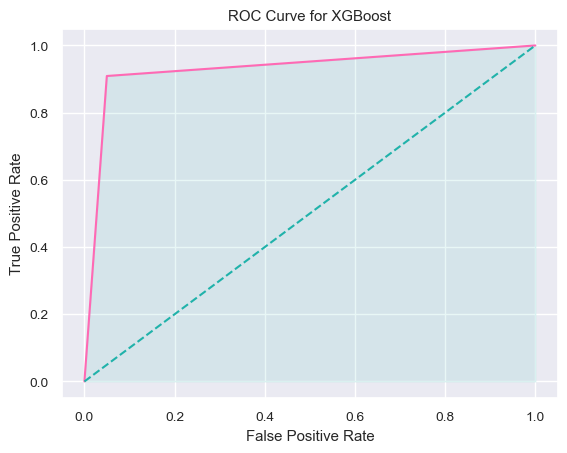

In [110]:
evaluation_suite(model=xgb_model, model_name='XGBoost', X=X, Y=Y)

At a **small tradeoff for accuracy**, using this XGBoost model can **improve some of the weaker areas** of Logistic Regression for a highly imbalanced dataset (for example, lowering the false negative rate). However, the F1 score does decrease for this implementation of XGBoost which can impact model selection if we were to decide between these two models.

I also wanted to look at **feature importance** (using XGBoost's built-in method) to see if my assumptions before model training/analysis help true.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

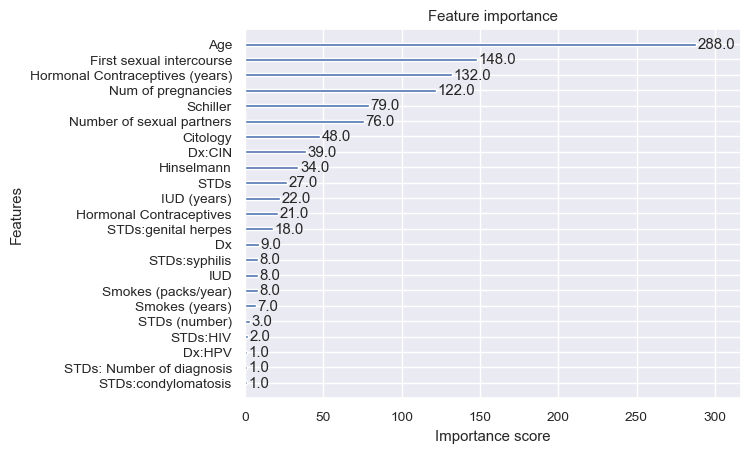

In [84]:
xgb_model.get_booster().feature_names = list(feature_df.columns)
xgb.plot_importance(xgb_model)

From this feature importance plot, we can see that **Age** is the biggest single determining factor in a cervical cancer diagnosis. This is very reasonable, since age is also a critical factor in other types of cancer. I'm surprised by the influence of Num of pregancies on cervical cancer, and I expected STD diagnoses to be of higher importance, but nothing in this plot looks suspicious to me from a data science perspective.

## Performing Hyperparameter Tuning on XGBoost Classifier

Finally, I'll do some **hyperparameter tuning** to test different values of max_depth and learning rate and see if I can make any more incremental improvements in performance. I used scoring based on optimizing 'average_precision', which is better than standard accuracy for this kind of highly imbalanced data.

In [115]:
# Using grid search method to find best combination of learning rate and max depth
lr_values_to_test = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
depth_values_to_test = list(range(1,30))

param_grid = {
    'learning_rate': lr_values_to_test,
    'max_depth': depth_values_to_test
}

xgb_to_optimize = xgb.XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos_weight, eval_metric='aucpr')

grid = GridSearchCV(estimator=xgb_to_optimize, param_grid=param_grid, cv=5, scoring='average_precision').fit(X, Y)
print(f'Best parameters from GridSearchCV: {grid.best_params_}')
print(f'Best avg precision score using tuned hyperparameters: {grid.best_score_:0.3f}')

Best parameters from GridSearchCV: {'learning_rate': 0.05, 'max_depth': 2}
Best avg precision score using tuned hyperparameters: 0.712


## Evaluation Metrics for XGBoost Classifier After Hyperparameter Tuning

XGBoost w/Tuning accuracy score: 0.953
XGBoost w/Tuning cross-validation mean score: 0.957
XGBoost w/Tuning F1 score: 0.714


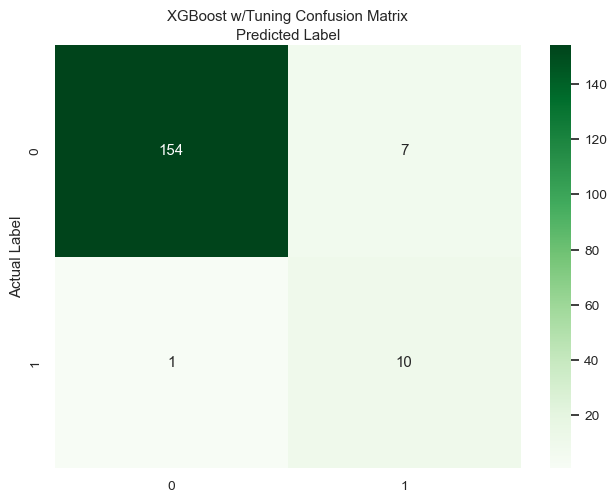

XGBoost w/Tuning false negative rate: 0.091
XGBoost w/Tuning ROC AUC: 0.933


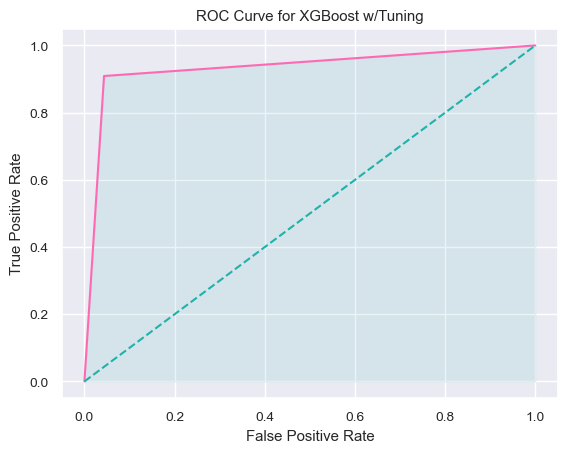

In [116]:
xgb_optimized = xgb.XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=100,
                                  scale_pos_weight=scale_pos_weight, eval_metric='aucpr').fit(X, Y)

evaluation_suite(model=xgb_optimized, model_name='XGBoost w/Tuning', X=X, Y=Y)

We see that this tuned version of XGBoost has the **best scores overall**, minimizing the false negative rate while improving F1 and keeping overall accuracy and cross-validation scores high.

I performed the same feature importance steps as before.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

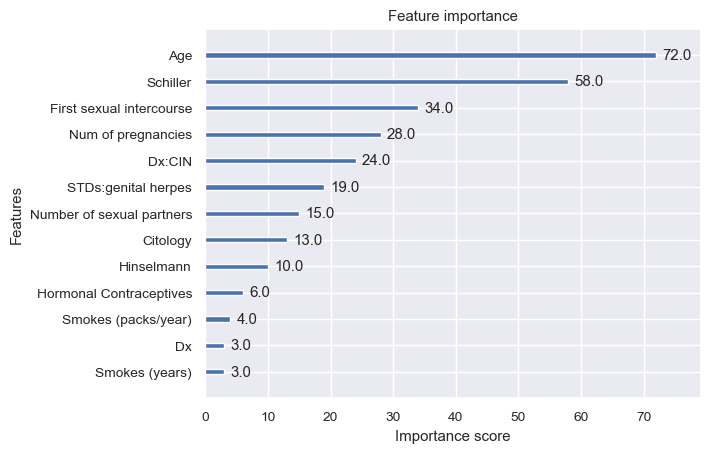

In [117]:
xgb_optimized.get_booster().feature_names = list(feature_df.columns)
xgb.plot_importance(xgb_optimized)

Here we can see that **Age** remains the single strongest determining factor in a cervical cancer diagnosis. Here however, the **Schiller** test is the next most important feature. This is a closer match to the information I saw in the correlation matrix, where the Schiller and other lab tests appeared to have a moderate-strong correlation with the Biopsy target. This is a reasonable conclusion, since abnormal cell tissue in the cervix would presumably be a strong indicator of the presence of cancer.

## Results and Discussion

The two different modeling approaches each had strengths and weaknesses, with logistic regression providing higher accuracy and F1 scores than un-tuned XGBoost, but a higher false negative rate and a less optimal ROC curve. This indicates to me that XGBoost may be better for handling highly imbalanced data than logistic regression.
After hyperparameter tuning, I was able to mitigate the lower scores for XGBoost (specifically F1) while leaving the false negative rate low and the overall accuracy high (over 95%). Because the optimal max_depth was so small and the optimal learning_rate was moderate, I am not concerned about overfitting of this model.

Overall, if I were to choose one of these modeling approaches to determine probable cervical cancer diagnoses based on the risk factors, it would be the tuned XGBoost classifier.

What was expecially cool about the results of the feature importance was comparing the most important factors in the best model to the correlation coefficients of individual features with Biopsy in the correlation matrix. The features of Age and First sexual intercourse appear to have virtually no relationship to the target on their own, but are majorly important in the XGBoost decision tree model.

If this approach was going to be deployed in real life, far more samples would need to be collected to ensure that the model has a bigger set of positive Biopsy results to learn from and mitigate some of the issues caused by imbalanced data. Beyond the hyperparameter tuning I used, I would also want to put in place measures to ensure overfitting isn't occurring and causing hugely variable results on new data. With greater domain knowledge or further testing, it's likely possible that some features could be removed.

For logistic regression specfically, another possible future improvement involves regularization. Muticollinearity is very possibly occuring among many of the featues that measure different elements of the same effect (ex: STDs and STDs (number) are both going to measure the same effect in different ways). Implementing something like ridge regression would reduce the chances of overfitting the logistic regression model, and would reduce the number of features used.
Luckily, another benefit of XGBoost (and decision tree classifiers generally) are that we don't need to worry about multicollinearity like we do in linear or logistic regression.